In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai import *
from google.colab import drive
import os
import shutil

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
bs = 64

In [4]:
path_to_tar = '/content/drive/My\ Drive/fast_ai/datasets/Indian-Snakes-Dataset.tar.xz'

In [5]:
! tar -xvf {path_to_tar}

Indian-Snakes-Dataset/
Indian-Snakes-Dataset/.git/
Indian-Snakes-Dataset/.git/description
Indian-Snakes-Dataset/.git/index
Indian-Snakes-Dataset/.git/config
Indian-Snakes-Dataset/.git/packed-refs
Indian-Snakes-Dataset/.git/HEAD
Indian-Snakes-Dataset/.git/info/
Indian-Snakes-Dataset/.git/info/exclude
Indian-Snakes-Dataset/.git/hooks/
Indian-Snakes-Dataset/.git/hooks/fsmonitor-watchman.sample
Indian-Snakes-Dataset/.git/hooks/prepare-commit-msg.sample
Indian-Snakes-Dataset/.git/hooks/pre-rebase.sample
Indian-Snakes-Dataset/.git/hooks/post-update.sample
Indian-Snakes-Dataset/.git/hooks/commit-msg.sample
Indian-Snakes-Dataset/.git/hooks/applypatch-msg.sample
Indian-Snakes-Dataset/.git/hooks/pre-push.sample
Indian-Snakes-Dataset/.git/hooks/pre-applypatch.sample
Indian-Snakes-Dataset/.git/hooks/update.sample
Indian-Snakes-Dataset/.git/hooks/pre-commit.sample
Indian-Snakes-Dataset/.git/hooks/pre-receive.sample
Indian-Snakes-Dataset/.git/branches/
Indian-Snakes-Dataset/.git/refs/
Indian-Snakes-

In [6]:
os.mkdir('data')

In [7]:
p = '/content/Indian-Snakes-Dataset/'
for dirs in os.listdir(p):
  if dirs != '.git':
    for subdirs in os.listdir(p+dirs):
      shutil.move(p+dirs+'/'+subdirs, '/content/data/')

In [8]:
doc(get_transforms)

In [17]:
trans = get_transforms(max_rotate=30, max_zoom=1.5, max_lighting=0.4, max_warp=0.5, p_affine=1., p_lighting=1.)

In [12]:
doc(ImageList)

In [13]:
path = Path('/content/data/')

In [15]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [21]:
def get_data(size, bs, padding_mode='reflection'):
  data = src.label_from_folder().transform(trans, size=size, padding_mode=padding_mode).databunch(bs=bs).normalize(imagenet_stats)
  return data

In [22]:
data = get_data(224, bs, 'zeros')

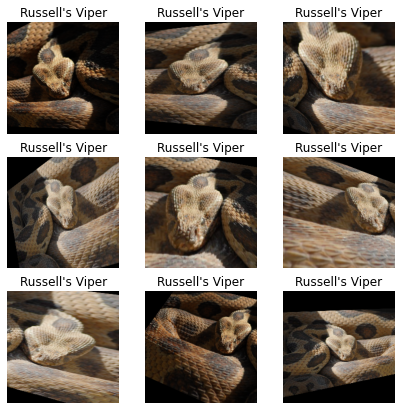

In [29]:
def plot(i,j,ax):
  x,y = data.train_ds[155]
  x.show(ax, y=y)

plot_multi(plot, 3, 3, figsize=(7,7))

In [30]:
data = get_data(224, bs, 'reflection')

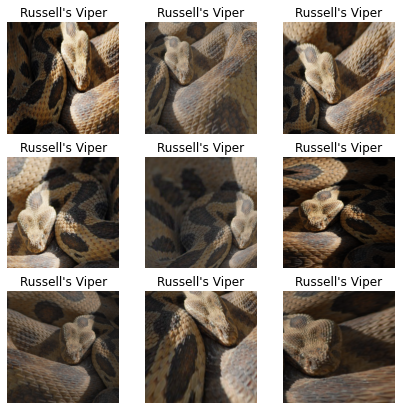

In [31]:
plot_multi(plot, 3, 3, figsize=(7,7))

## **Create a CNN**

In [34]:
gc.collect()
cnn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [35]:
cnn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.299978,1.244817,0.382022,01:08
1,1.823161,0.972755,0.306180,01:08
2,1.546720,0.889864,0.294944,01:09


In [36]:
cnn.unfreeze()
cnn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.196276,0.882027,0.278090,01:11
1,1.154954,0.849293,0.247191,01:11


In [37]:
data = get_data(352,bs)
cnn.data = data

In [38]:
cnn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.086859,0.844185,0.252809,01:42
1,1.067913,0.845729,0.247191,01:40


In [39]:
cnn.save('model-352')

## **Convolution Behind the scenes**

In [40]:
data = get_data(352, 16)

In [41]:
cnn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('model-352')

Checkered Keelback


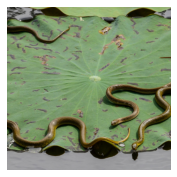

In [99]:
idx = 137
x,y = data.valid_ds[idx]
x.show()
print (y)

In [100]:
cnn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

In [101]:
kernel = tensor([[0,-5/3, 1],
                 [-5/3,-5/3,1],
                 [1,1,1]]).expand(1,3,3,3)/6

In [102]:
kernel, kernel.shape

(tensor([[[[ 0.0000, -0.2778,  0.1667],
           [-0.2778, -0.2778,  0.1667],
           [ 0.1667,  0.1667,  0.1667]],
 
          [[ 0.0000, -0.2778,  0.1667],
           [-0.2778, -0.2778,  0.1667],
           [ 0.1667,  0.1667,  0.1667]],
 
          [[ 0.0000, -0.2778,  0.1667],
           [-0.2778, -0.2778,  0.1667],
           [ 0.1667,  0.1667,  0.1667]]]]), torch.Size([1, 3, 3, 3]))

In [103]:
from fastai.callbacks.hooks import *

In [108]:
t = data.valid_ds[137][0].data; t.shape

torch.Size([3, 352, 352])

In [109]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [110]:
edge = F.conv2d(t[None], kernel)

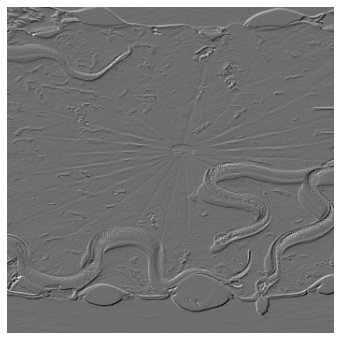

In [111]:
show_image(edge[0], figsize=(6,6))

# **Heat Map**

In [112]:
model = cnn.model.eval()

In [113]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [114]:
def hooked_backward(cat=y):
  with hook_output(model[0]) as hook_a:
    with hook_output(model[0], grad=True) as hook_g:
      preds = model(xb)
      preds[0,int(cat)].backward()
  return hook_a, hook_g

In [115]:
hook_a, hook_g = hooked_backward()

In [116]:
activations = hook_a.stored[0].cpu()
activations.shape

torch.Size([512, 11, 11])

In [117]:
avg_acts = activations.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [118]:
def heatmap(hm):
  _,ax = plt.subplots()
  xb_im.show(ax)
  ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma')

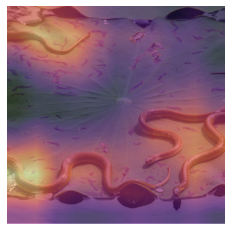

In [119]:
heatmap(avg_acts)